In [ ]:
import os
import zipfile
import cv2 as cv
import numpy as np
import pandas as pd
from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False)

Mounted at /content/gdrive


In [ ]:
DATASET_PATH = '/content/gdrive/My Drive/MPIIGaze.zip'
zip_object = zipfile.ZipFile(file=DATASET_PATH, mode='r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
root_mpi_dir = 'content'
data_dir = '/content/Data'
annot_dir = '/content/Annotation Subset'
img_dir = os.path.join(data_dir, 'Original')



In [ ]:
def read_annot(in_path):
    r_dir = os.path.splitext(os.path.basename(in_path))[0]
    c_df = pd.read_table(in_path, header=None, sep=' ')
    c_df.columns = ['path' if i < 0 else ('x{}'.format(i // 2) if i % 2 == 0 else 'y{}'.format(i // 2)) for i, x in
                    enumerate(c_df.columns, -1)]
    c_df['path'] = c_df['path'].map(lambda x: os.path.join(img_dir, r_dir, x))
    c_df['group'] = r_dir
    c_df['exists'] = c_df['path'].map(os.path.exists)
    return c_df

all_annot_df = pd.concat([read_annot(c_path) for c_path in glob(os.path.join(annot_dir, '*'))], ignore_index=True)
all_annot_df = all_annot_df[all_annot_df['exists']].drop('exists', 1)



<ipython-input-5-13a43b3469d3>:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  all_annot_df = all_annot_df[all_annot_df['exists']].drop('exists', 1)


In [ ]:
def get_eyeball(in_row, eye_height=30):
    c_img = imread(in_row['path'])
    min_x = int(in_row['x0'])
    max_x = int(in_row['x1'])

    mean_x = (min_x + max_x) / 2
    wid_x = (max_x - min_x)
    zoom_factor = 55.0 / wid_x

    mean_y = (in_row['y0'] + in_row['y1']) / 2
    eye_height = 1 / zoom_factor * 35

    pup_v = 2 * zoom_factor * (in_row['x6'] - mean_x) / wid_x, 2 * zoom_factor * (in_row['y6'] - mean_y) / eye_height

    min_y = int(mean_y - eye_height // 2)
    max_y = int(mean_y + eye_height // 2)
    out_img = c_img[min_y:max_y, min_x:max_x]
    rs_img = cv.resize(out_img, (224, 224))
    return rs_img, pup_v

all_annot_df['eyeball'] = all_annot_df.apply(get_eyeball, 1)
all_annot_df['pupil_x'] = all_annot_df['eyeball'].map(lambda x: x[1][0])
all_annot_df['pupil_y'] = all_annot_df['eyeball'].map(lambda x: x[1][1])
all_annot_df['eyeball'] = all_annot_df['eyeball'].map(lambda x: x[0])



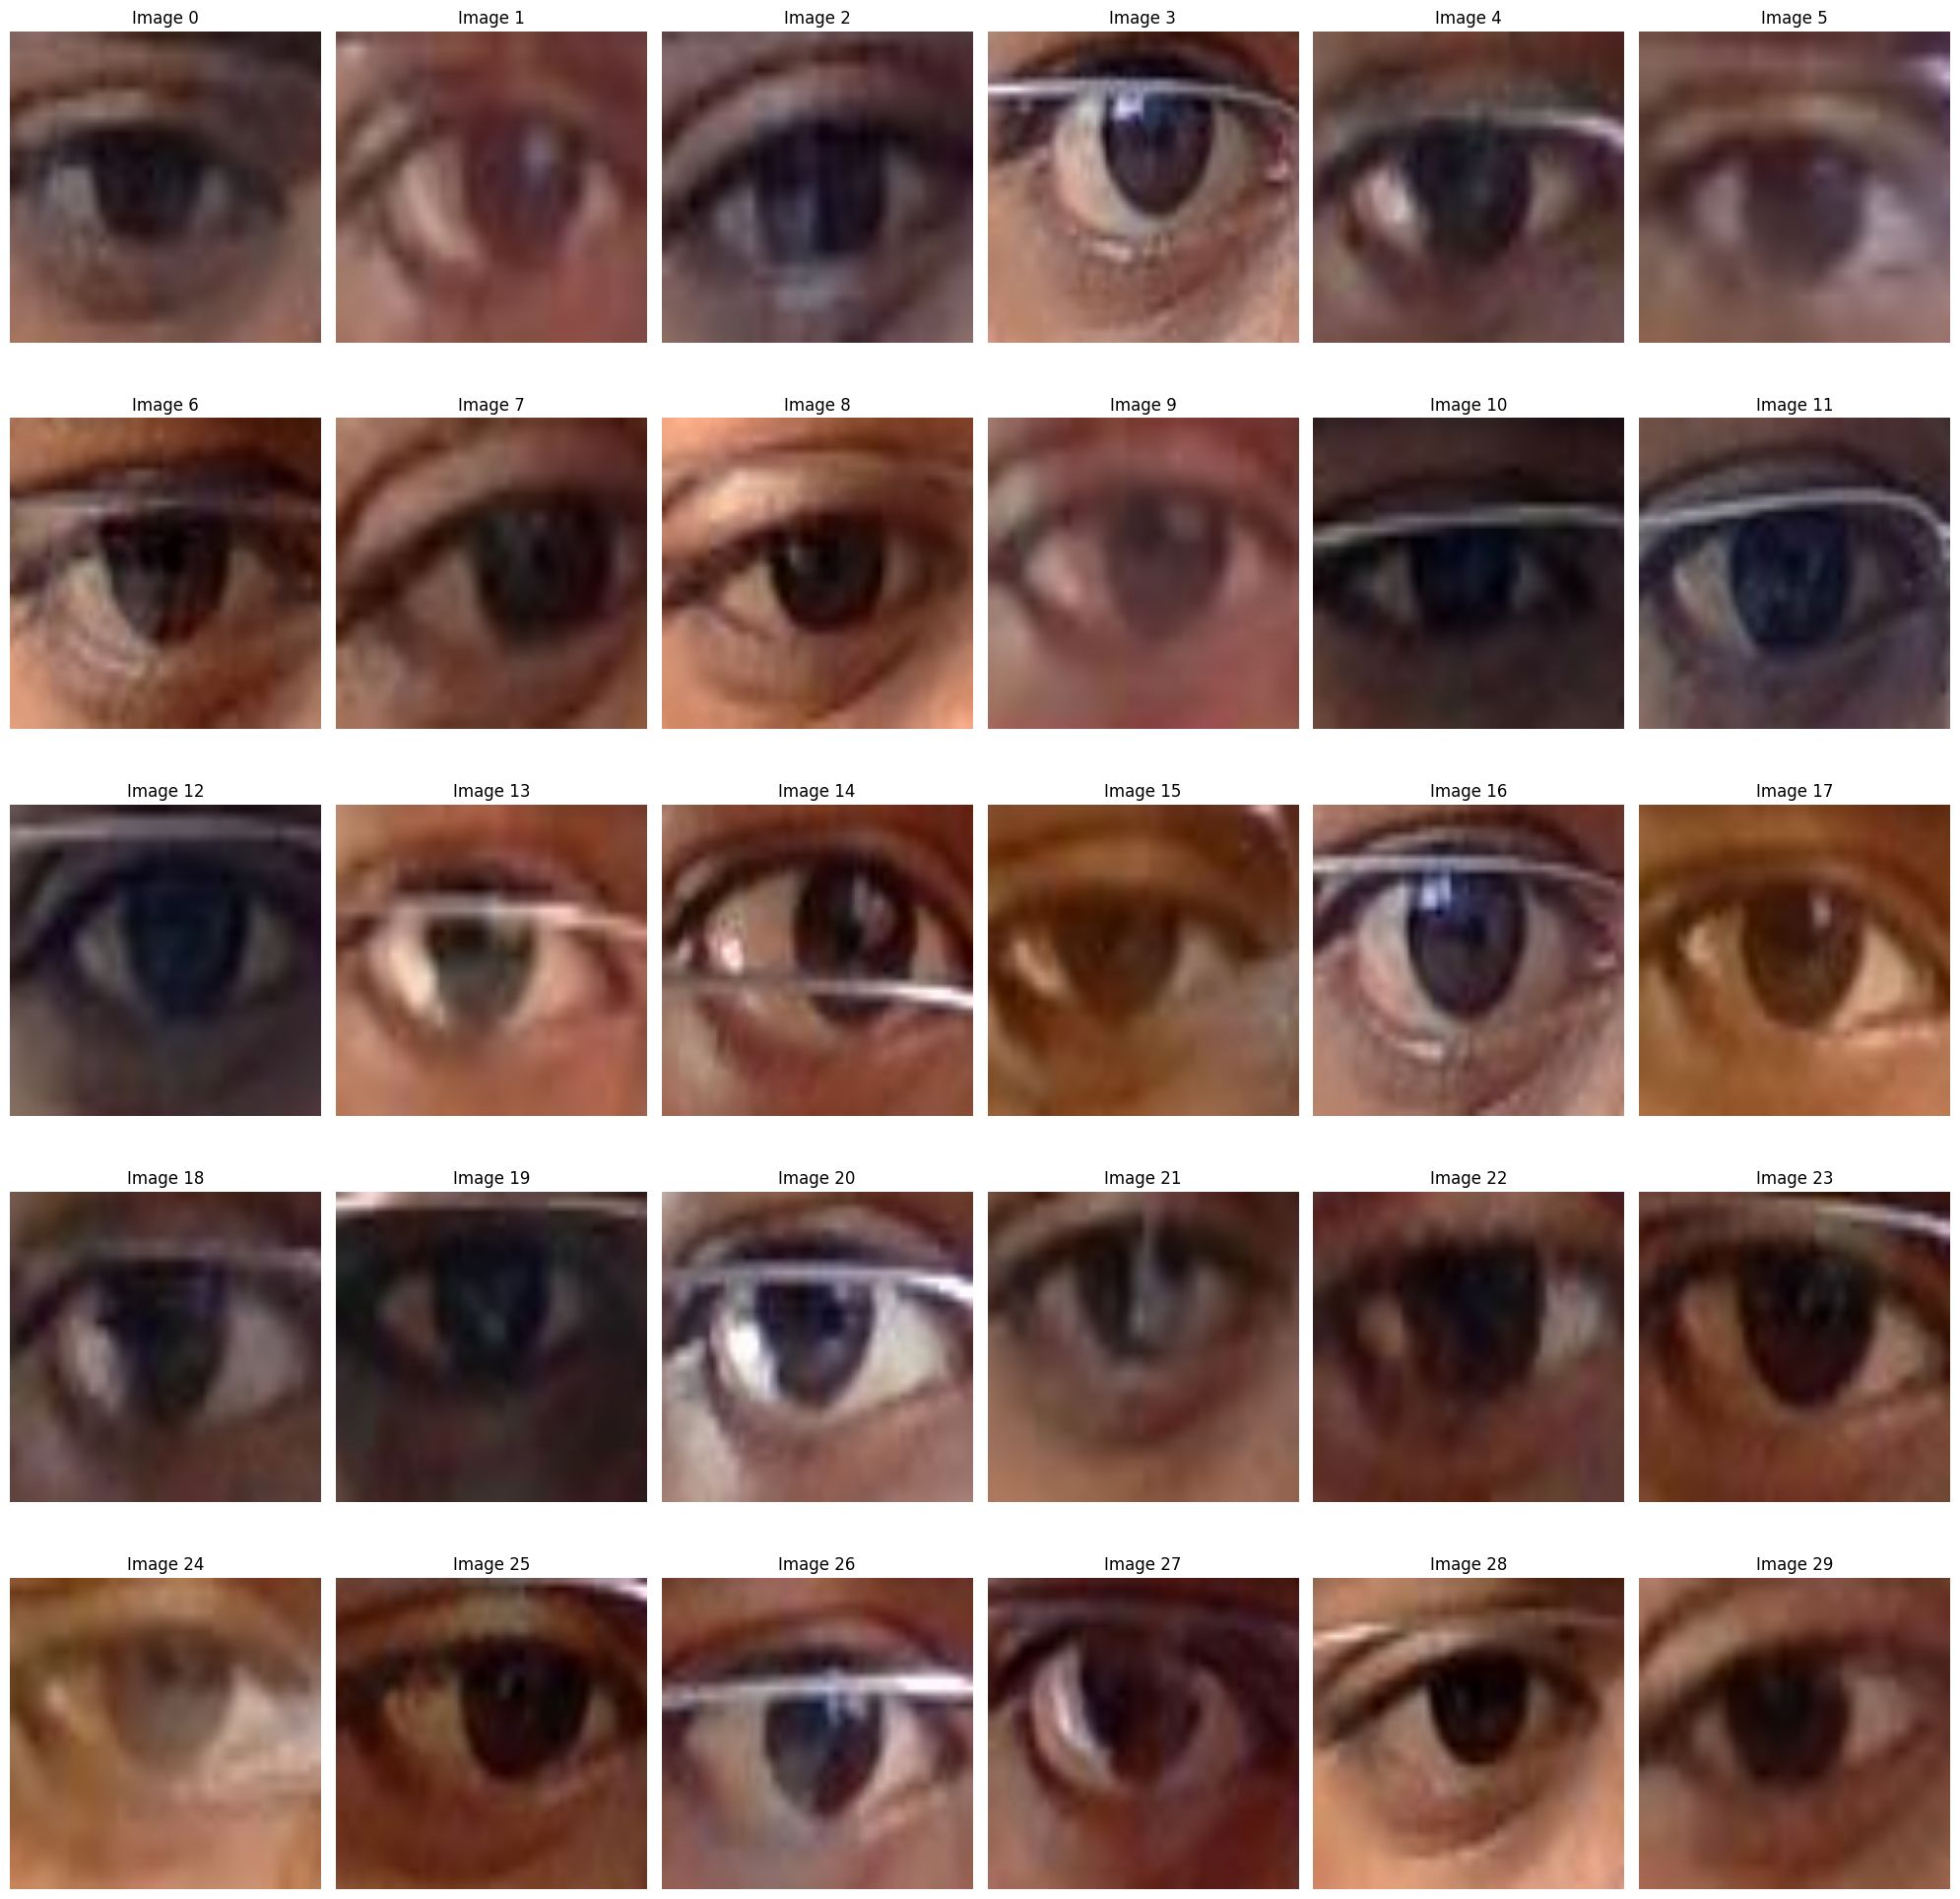

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have prepared the all_annot_df DataFrame with 'eyeball' column containing resized images

# List of indices of images you want to display
num_images_to_display = 30

# Display a set of resized eye ball images from the DataFrame
def display_multiple_resized_images(images_df, num_images):
    plt.figure(figsize=(20, 20))

    for i, index in enumerate(range(num_images)):
        plt.subplot(5, 6, i + 1)  # Display in a 5x6 grid
        plt.imshow(images_df.loc[index, 'eyeball'])
        plt.axis('off')
        plt.title(f"Image {index}")

    plt.tight_layout()
    plt.show()

# Call the function to display about 30 resized eye ball images from the DataFrame
display_multiple_resized_images(all_annot_df, num_images_to_display)


In [ ]:
def preprocess_image(img_path):
    img = cv.imread(img_path)
    img = cv.resize(img, (224, 224))  # Resize image to match VGG16 input size
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert to RGB
    img = keras.applications.vgg16.preprocess_input(img)  # Preprocess input for VGG16
    return img

In [ ]:
# Prepare feature vectors and labels
X = np.array([preprocess_image(path) for path in all_annot_df['path']])
y = all_annot_df[['pupil_x', 'pupil_y']].values

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Step 6: VGG-16 Model (without softmax layer)
# Load the VGG-16 model without the top (fully connected) layers and set it to non-trainable
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Step 7: Add custom classification layers on top of VGG-16
# Flatten the output from VGG-16 and add a fully connected layer and the XGBoost classifier
x = vgg_model.output
x = GlobalAveragePooling2D()(x)
output = keras.layers.Dense(2)(x)  # Output layer for x and y coordinates
model = Model(inputs=vgg_model.input, outputs=output)


In [ ]:
# Step 8: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [ ]:
# Step 9: Training
# Use appropriate batch size and epochs based on your dataset
batch_size = 32
epochs = 50

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/50
267/267 [==============================] - 19s 38ms/step - loss: 0.3024 - accuracy: 0.5517 - val_loss: 0.0996 - val_accuracy: 0.5711
Epoch 2/50
267/267 [==============================] - 8s 29ms/step - loss: 0.0678 - accuracy: 0.5956 - val_loss: 0.0531 - val_accuracy: 0.5983
Epoch 3/50
267/267 [==============================] - 8s 29ms/step - loss: 0.0419 - accuracy: 0.6274 - val_loss: 0.0360 - val_accuracy: 0.6302
Epoch 4/50
267/267 [==============================] - 8s 29ms/step - loss: 0.0301 - accuracy: 0.6514 - val_loss: 0.0291 - val_accuracy: 0.6115
Epoch 5/50
267/267 [==============================] - 8s 29ms/step - loss: 0.0241 - accuracy: 0.6704 - val_loss: 0.0237 - val_accuracy: 0.6739
Epoch 6/50
267/267 [==============================] - 8s 29ms/step - loss: 0.0212 - accuracy: 0.6791 - val_loss: 0.0215 - val_accuracy: 0.6856
Epoch 7/50
267/267 [==============================] - 8s 29ms/step - loss: 0.0197 - accuracy: 0.6935 - val_loss: 0.0198 - val_accuracy: 0.684

In [ ]:
# Extract features from the dataset using the modified VGG-16 model
features_train = model.predict(X_train)
features_test = model.predict(X_test)

67/67 [==============================] - 1s 21ms/step


In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
}


In [ ]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_model, param_grid=param_grid, cv=5)
grid_search.fit(features_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]})

In [ ]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict on the test set
vggm_pred = best_model.predict(features_test)


In [ ]:
# Calculate the mean squared error (MSE) for the XGBoost model
mse = mean_squared_error(y_test, vggm_pred)

# Calculate the accuracy based on MSE (lower MSE is better)
accuracy = 1.0 / (1.0 + mse)

print(f"Best hyperparameters: {grid_search.best_params_}")
# print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")


Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Mean Squared Error (MSE): 0.0160
Accuracy: 98.42%


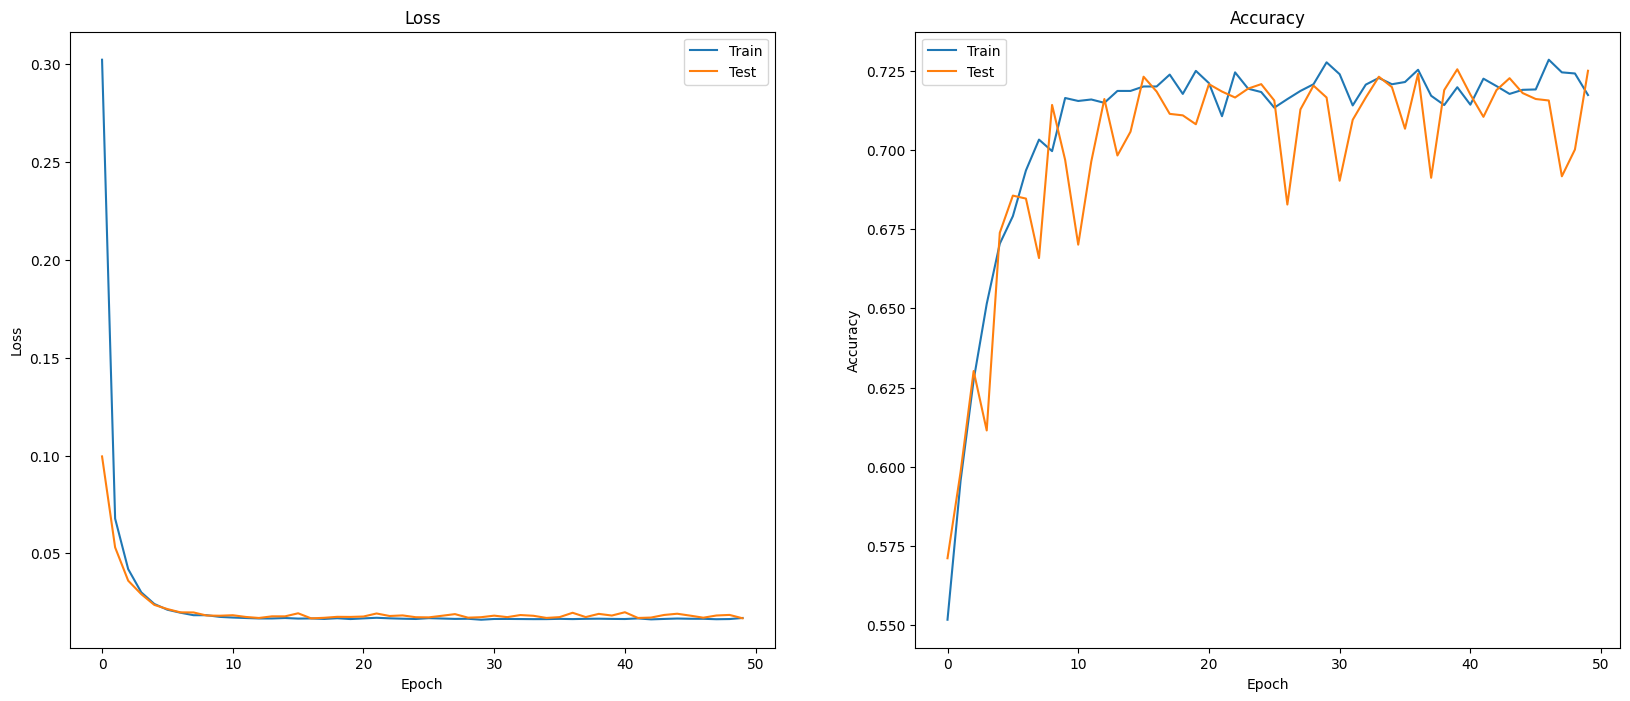

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and test learning curves
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='test')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='test')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'])

    plt.show()

plot_history(history)


VGG16

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_model.layers:
    layer.trainable = False

# Step 7: Add custom classification layers on top of VGG-16
# Flatten the output from VGG-16 and add a fully connected layer and the XGBoost classifier
x = vgg_model.output
x = GlobalAveragePooling2D()(x)
output = keras.layers.Dense(2)(x)  # Output layer for x and y coordinates
model_vgg = Model(inputs=vgg_model.input, outputs=output)

# Step 8: Compile the model
model_vgg.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [ ]:
# Step 9: Training
batch_size = 64
epochs = 10

# Training the model and keeping track of history
history = model_vgg.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/10
134/134 [==============================] - 10s 62ms/step - loss: 0.3876 - accuracy: 0.5417 - val_loss: 0.1713 - val_accuracy: 0.5115
Epoch 2/10
134/134 [==============================] - 7s 54ms/step - loss: 0.1269 - accuracy: 0.5513 - val_loss: 0.0972 - val_accuracy: 0.5617
Epoch 3/10
134/134 [==============================] - 7s 54ms/step - loss: 0.0825 - accuracy: 0.5739 - val_loss: 0.0702 - val_accuracy: 0.5899
Epoch 4/10
134/134 [==============================] - 7s 54ms/step - loss: 0.0616 - accuracy: 0.5884 - val_loss: 0.0555 - val_accuracy: 0.6077
Epoch 5/10
134/134 [==============================] - 7s 54ms/step - loss: 0.0491 - accuracy: 0.6052 - val_loss: 0.0464 - val_accuracy: 0.6227
Epoch 6/10
134/134 [==============================] - 7s 54ms/step - loss: 0.0409 - accuracy: 0.6134 - val_loss: 0.0392 - val_accuracy: 0.6260
Epoch 7/10
134/134 [==============================] - 7s 54ms/step - loss: 0.0351 - accuracy: 0.6250 - val_loss: 0.0348 - val_accuracy: 0.600

In [ ]:
# Evaluate the model on the test set
vgg_pred = model.predict(X_test)
mse = mean_squared_error(y_test, vgg_pred)
accuracy = 1.0 / (1.0 + mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

67/67 [==============================] - 1s 21ms/step
Mean Squared Error (MSE): 0.0168
Accuracy: 98.35%


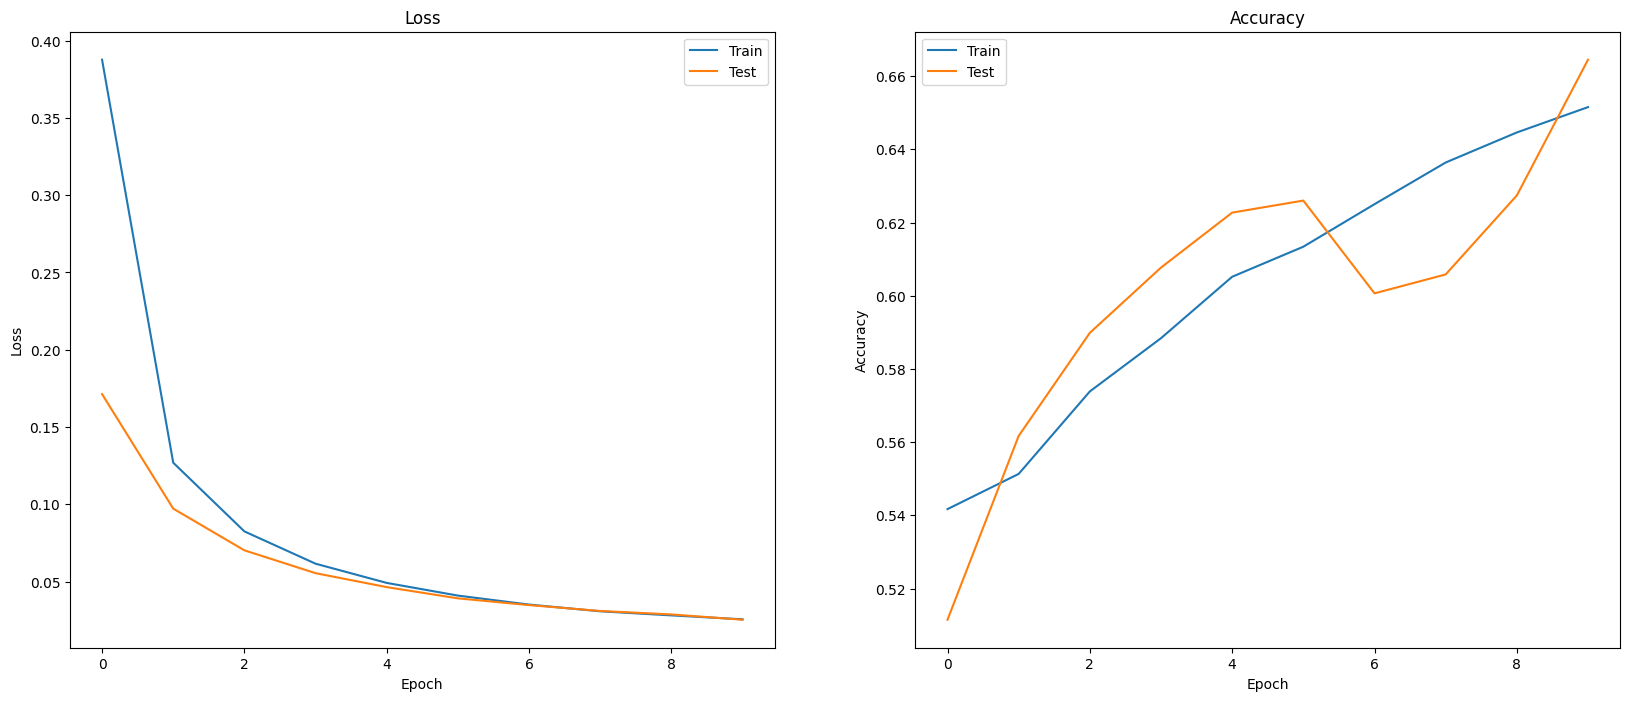

In [ ]:
# Plotting training and test learning curves
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='test')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='test')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'])

    plt.show()

plot_history(history)


ReSNET50

In [ ]:
import os
import zipfile
import cv2 as cv
import numpy as np
import pandas as pd
from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split
import keras
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt




In [ ]:
# Step 6: ResNet50 Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2)(x)  # Output layer for x and y coordinates

model = Model(inputs=base_model.input, outputs=predictions)



94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
# Step 7: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])



In [ ]:
# Step 9: Training
batch_size = 64
epochs = 10

# Training the model and keeping track of history
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Rest of your code for evaluation and plotting remains the same...

Epoch 1/10
134/134 [==============================] - 13s 97ms/step - loss: 0.0086 - accuracy: 0.8138 - val_loss: 0.0160 - val_accuracy: 0.7405
Epoch 2/10
134/134 [==============================] - 12s 91ms/step - loss: 0.0085 - accuracy: 0.8234 - val_loss: 0.0151 - val_accuracy: 0.7508
Epoch 3/10
134/134 [==============================] - 12s 91ms/step - loss: 0.0077 - accuracy: 0.8280 - val_loss: 0.0272 - val_accuracy: 0.5659
Epoch 4/10
134/134 [==============================] - 12s 91ms/step - loss: 0.0072 - accuracy: 0.8349 - val_loss: 0.0148 - val_accuracy: 0.7485
Epoch 5/10
134/134 [==============================] - 12s 91ms/step - loss: 0.0067 - accuracy: 0.8383 - val_loss: 0.0236 - val_accuracy: 0.7602
Epoch 6/10
134/134 [==============================] - 12s 91ms/step - loss: 0.0058 - accuracy: 0.8560 - val_loss: 0.0227 - val_accuracy: 0.7250
Epoch 7/10
134/134 [==============================] - 12s 91ms/step - loss: 0.0054 - accuracy: 0.8613 - val_loss: 0.0174 - val_accuracy:

In [ ]:
# Evaluate the model on the test set
resnet_pred = model.predict(X_test)
mse = mean_squared_error(y_test, resnet_pred)
accuracy = 1.0 / (1.0 + mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

67/67 [==============================] - 1s 14ms/step
Mean Squared Error (MSE): 0.0173
Accuracy: 98.30%


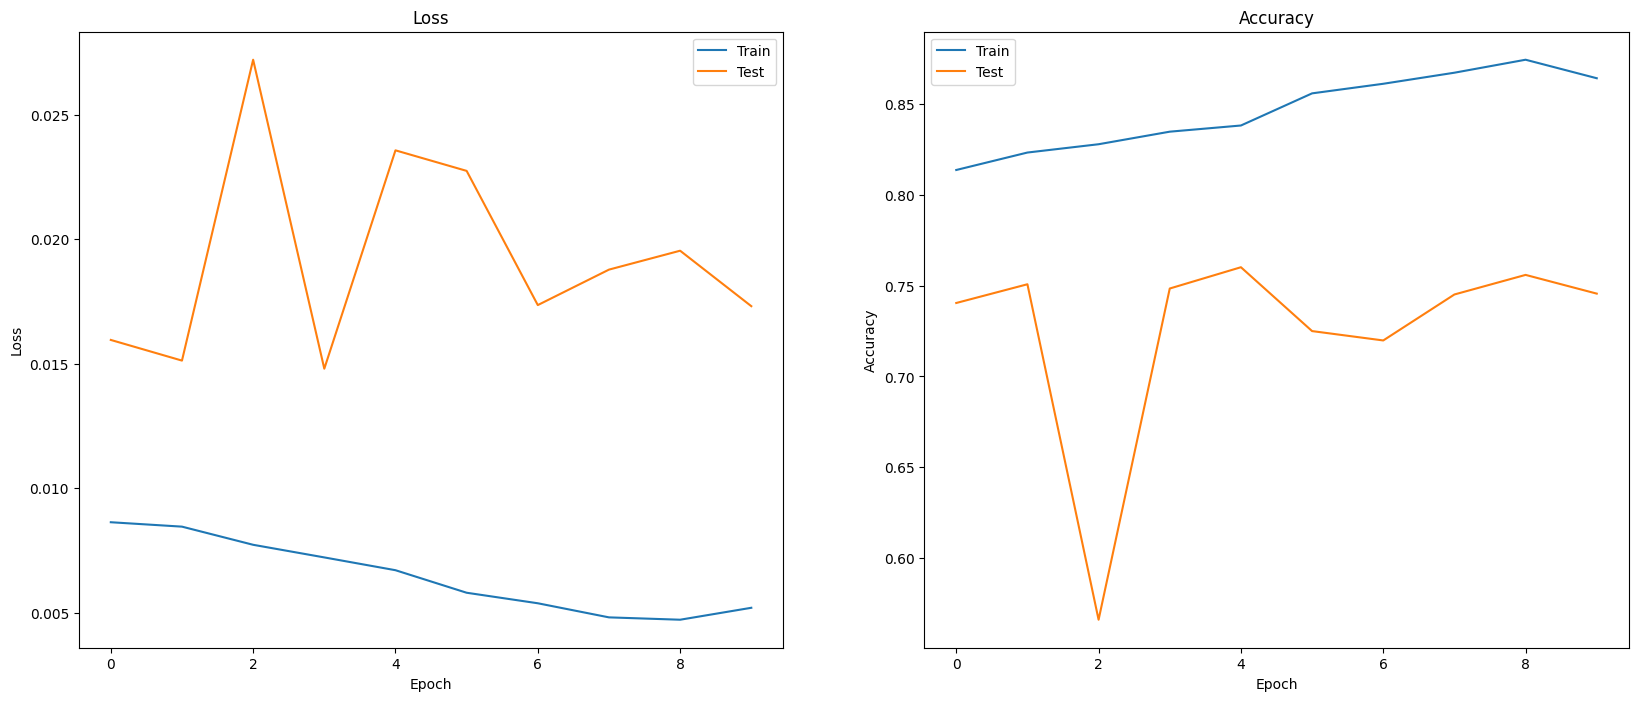

In [ ]:
# Plotting training and test learning curves
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='test')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='test')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'])

    plt.show()

plot_history(history)

MobileNetV2

In [ ]:
import os
import zipfile
import cv2 as cv
import numpy as np
import pandas as pd
from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split
import keras
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt



In [ ]:
# Step 6: MobileNetV2 Model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2)(x)  # Output layer for x and y coordinates

model = Model(inputs=base_model.input, outputs=predictions)




9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Step 7: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])



In [ ]:
# Step 9: Training
batch_size = 64
epochs = 50

# Training the model and keeping track of history
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Rest of your code for evaluation and plotting remains the same...

Epoch 1/50
134/134 [==============================] - 42s 92ms/step - loss: 0.0436 - accuracy: 0.7027 - val_loss: 2.1708 - val_accuracy: 0.2816
Epoch 2/50
134/134 [==============================] - 10s 73ms/step - loss: 0.0162 - accuracy: 0.7237 - val_loss: 0.8432 - val_accuracy: 0.2816
Epoch 3/50
134/134 [==============================] - 10s 73ms/step - loss: 0.0151 - accuracy: 0.7292 - val_loss: 0.1239 - val_accuracy: 0.2816
Epoch 4/50
134/134 [==============================] - 10s 73ms/step - loss: 0.0138 - accuracy: 0.7423 - val_loss: 0.0215 - val_accuracy: 0.7081
Epoch 5/50
134/134 [==============================] - 10s 73ms/step - loss: 0.0132 - accuracy: 0.7426 - val_loss: 0.0213 - val_accuracy: 0.7147
Epoch 6/50
134/134 [==============================] - 10s 74ms/step - loss: 0.0125 - accuracy: 0.7531 - val_loss: 0.0212 - val_accuracy: 0.7175
Epoch 7/50
134/134 [==============================] - 10s 73ms/step - loss: 0.0114 - accuracy: 0.7683 - val_loss: 0.0275 - val_accuracy:

In [ ]:
# Evaluate the model on the test set
mnet_pred = model.predict(X_test)
mse = mean_squared_error(y_test, mnet_pred)
accuracy = 1.0 / (1.0 + mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

67/67 [==============================] - 1s 11ms/step
Mean Squared Error (MSE): 0.0183
Accuracy: 98.20%


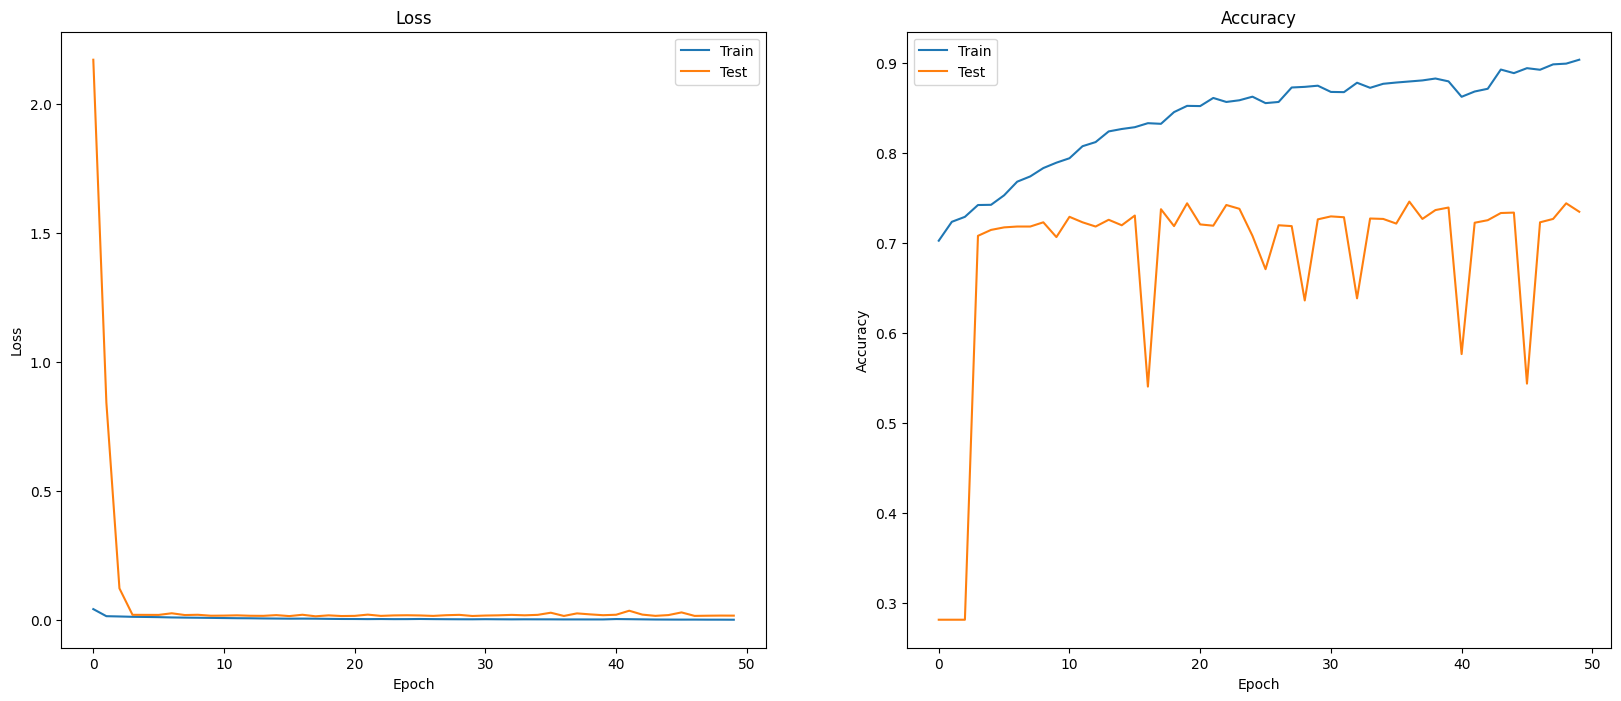

In [ ]:
# Plotting training and test learning curves
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='test')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='test')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'])

    plt.show()

plot_history(history)

`Inception V3

In [ ]:
import os
import zipfile
import cv2 as cv
import numpy as np
import pandas as pd
from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split
import keras
from keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt




In [ ]:
# Step 6: InceptionV3 Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2)(x)  # Output layer for x and y coordinates

model = Model(inputs=base_model.input, outputs=predictions)


87910968/87910968 [==============================] - 1s 0us/step


In [ ]:

# Step 7: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])



In [ ]:
# Step 9: Training
batch_size = 64
epochs = 10

# Training the model and keeping track of history
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Rest of your code for evaluation and plotting remains the same...

Epoch 1/10
134/134 [==============================] - 57s 132ms/step - loss: 0.0692 - accuracy: 0.7037 - val_loss: 0.0193 - val_accuracy: 0.7180
Epoch 2/10
134/134 [==============================] - 12s 91ms/step - loss: 0.0160 - accuracy: 0.7266 - val_loss: 0.0195 - val_accuracy: 0.6748
Epoch 3/10
134/134 [==============================] - 12s 91ms/step - loss: 0.0147 - accuracy: 0.7326 - val_loss: 0.0167 - val_accuracy: 0.7292
Epoch 4/10
134/134 [==============================] - 12s 92ms/step - loss: 0.0139 - accuracy: 0.7405 - val_loss: 0.0191 - val_accuracy: 0.7391
Epoch 5/10
134/134 [==============================] - 12s 91ms/step - loss: 0.0130 - accuracy: 0.7455 - val_loss: 0.0167 - val_accuracy: 0.7330
Epoch 6/10
134/134 [==============================] - 12s 91ms/step - loss: 0.0121 - accuracy: 0.7605 - val_loss: 0.0190 - val_accuracy: 0.7344
Epoch 7/10
134/134 [==============================] - 12s 91ms/step - loss: 0.0115 - accuracy: 0.7692 - val_loss: 0.0161 - val_accuracy

In [ ]:
# Evaluate the model on the test set
inv_pred = model.predict(X_test)
mse = mean_squared_error(y_test, inv_pred)
accuracy = 1.0 / (1.0 + mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")

67/67 [==============================] - 3s 14ms/step
Mean Squared Error (MSE): 0.0150
Accuracy: 98.52%


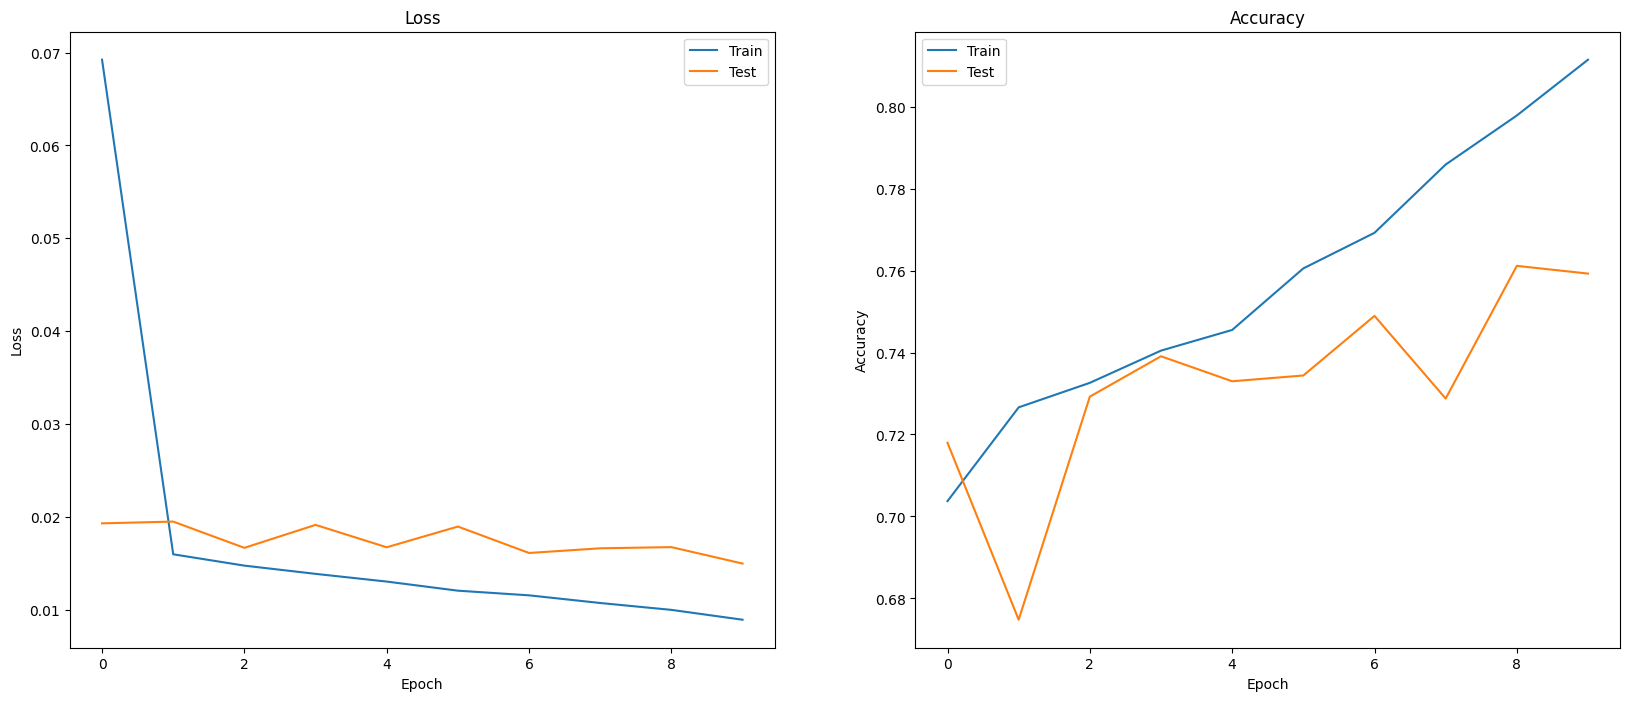

In [ ]:
# Plotting training and test learning curves
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 8)

    # Plot loss
    ax1.set_title('Loss')
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='test')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Test'])

    # Plot accuracy
    ax2.set_title('Accuracy')
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='test')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Test'])

    plt.show()

plot_history(history)